<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/microclimate_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install  "numpy==1.26.4" "scipy==1.11.4" \
  "tensorflow==2.18.*" "tensorflow-model-optimization==0.8.0" "keras-tuner==1.4.7"\
  "pandas==2.2.2" "requests==2.32.4" "scikit-learn==1.3.2"

In [4]:
# Use postponed evaluation of annotations (must be first)
from __future__ import annotations

# -----------------------------
# Standard library imports
# -----------------------------
import os
import math
import time
import json
import shutil
from datetime import date, datetime, timedelta, timezone
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

# Configure Keras 3 to use TensorFlow as the backend BEFORE importing keras
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ.pop("TF_USE_LEGACY_KERAS", None)
# Also avoid stand-alone Keras collisions
os.environ.pop("KERAS_BACKEND", None)

# -----------------------------
# Third-party libraries
# -----------------------------
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
import tensorflow_model_optimization as tfmot

# Determinism: seed all the things Keras knows about
keras.utils.set_random_seed(42)



In [5]:
def fetch_couva_weather_data(
    latitude: float = 10.44,
    longitude: float = -61.44,
    total_days: int = 365,
    safety_lag_days: int = 5
) -> pd.DataFrame:
    """
    Fetch hourly weather data for Couva, Trinidad from open-meteo.com.

    Args:
        latitude: Geographic latitude of Couva in decimal degrees.
        longitude: Geographic longitude of Couva in decimal degrees.
        total_days: Number of days of historical data to retrieve.
        safety_lag_days: Buffer days to ensure only finalized historical data.

    Returns:
        A DataFrame indexed by local datetime with columns:
        ['temperature', 'humidity', 'pressure', 'wind_speed', 'precipitation'].
    """
    end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)
    start_date: date = end_date - timedelta(days=total_days)

    api_base_url: str = "https://archive-api.open-meteo.com/v1/era5"
    query_parameters: Dict[str, Any] = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "hourly": ",".join([
            "temperature_2m",
            "relative_humidity_2m",
            "surface_pressure",
            "wind_speed_10m",
            "precipitation"
        ]),
        "timezone": "America/Port_of_Spain"
    }

    response = requests.get(api_base_url, params=query_parameters, timeout=60)
    response.raise_for_status()
    weather_json: Dict[str, Any] = response.json()

    datetimes_local = pd.to_datetime(weather_json["hourly"]["time"])
    weather_dataframe = pd.DataFrame({
        "temperature": weather_json["hourly"]["temperature_2m"],
        "humidity": weather_json["hourly"]["relative_humidity_2m"],
        "pressure": weather_json["hourly"]["surface_pressure"],
        "wind_speed": weather_json["hourly"]["wind_speed_10m"],
        "precipitation": weather_json["hourly"]["precipitation"],
    }, index=datetimes_local)

    # Ensure chronological order and fill tiny gaps
    weather_dataframe = weather_dataframe.sort_index().interpolate(limit_direction="both")

    return weather_dataframe

# Call the function to actually fetch the data
couva_weather_dataframe: pd.DataFrame = fetch_couva_weather_data()
# print a quick summary
print(couva_weather_dataframe.head(), couva_weather_dataframe.tail(), couva_weather_dataframe.shape)


/tmp/ipython-input-4277003254.py:20: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date: date = datetime.utcnow().date() - timedelta(days=safety_lag_days)


                     temperature  humidity  pressure  wind_speed  \
2024-10-22 00:00:00         26.6        86    1008.6         7.6   
2024-10-22 01:00:00         26.4        87    1008.0         9.4   
2024-10-22 02:00:00         26.2        88    1007.8         9.8   
2024-10-22 03:00:00         26.3        87    1007.6         9.1   
2024-10-22 04:00:00         26.2        87    1007.3         9.1   

                     precipitation  
2024-10-22 00:00:00            0.0  
2024-10-22 01:00:00            0.0  
2024-10-22 02:00:00            0.0  
2024-10-22 03:00:00            0.0  
2024-10-22 04:00:00            0.0                        temperature  humidity  pressure  wind_speed  \
2025-10-22 19:00:00         24.9        90    1008.8        12.6   
2025-10-22 20:00:00         25.3        90    1009.3        12.2   
2025-10-22 21:00:00         25.2        91    1010.0        11.3   
2025-10-22 22:00:00         25.3        90    1010.3        10.4   
2025-10-22 23:00:00         2

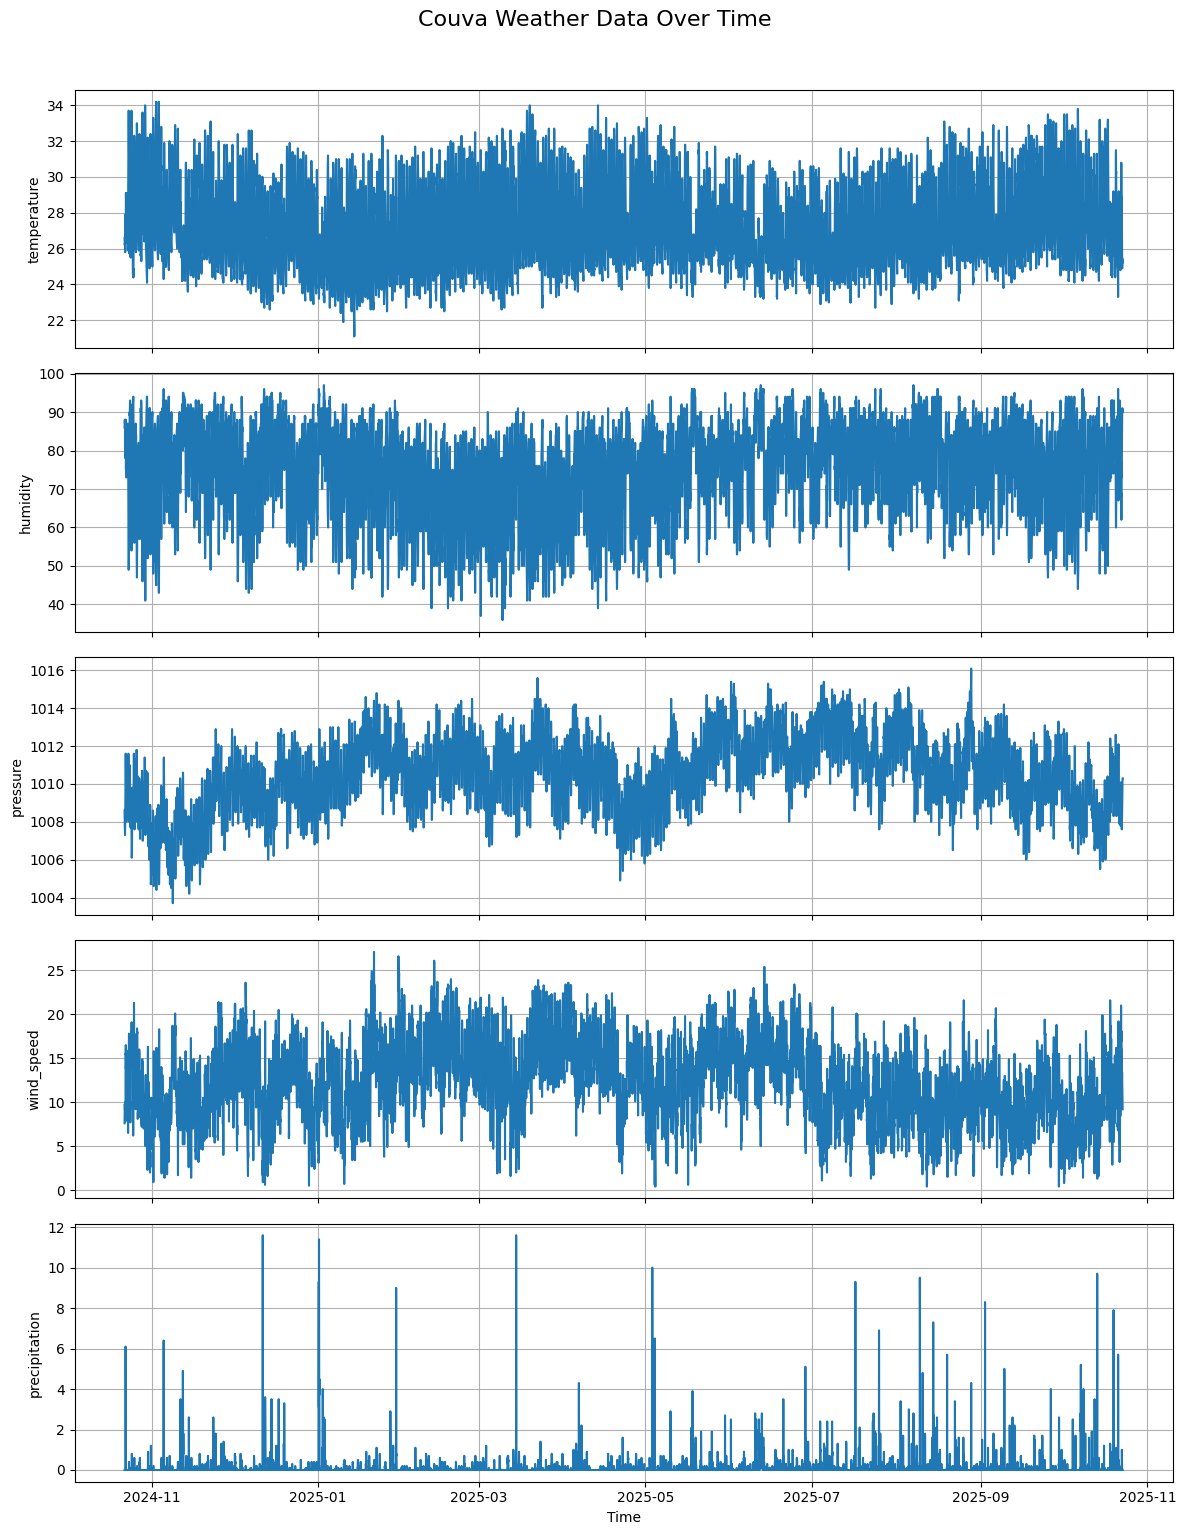

In [6]:
# Plot each weather feature over time so we can see what it looks like
fig, axes = plt.subplots(nrows=len(couva_weather_dataframe.columns), ncols=1, figsize=(12, 15), sharex=True)

for i, col in enumerate(couva_weather_dataframe.columns):
    axes[i].plot(couva_weather_dataframe.index, couva_weather_dataframe[col])
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.xlabel("Time")
fig.suptitle("Couva Weather Data Over Time", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Add time-based features
couva_weather_dataframe['hour'] = couva_weather_dataframe.index.hour
couva_weather_dataframe['day_of_week'] = couva_weather_dataframe.index.dayofweek
couva_weather_dataframe['month'] = couva_weather_dataframe.index.month

# Display the updated dataframe with new features
print(couva_weather_dataframe.head())

                     temperature  humidity  pressure  wind_speed  \
2024-10-22 00:00:00         26.6        86    1008.6         7.6   
2024-10-22 01:00:00         26.4        87    1008.0         9.4   
2024-10-22 02:00:00         26.2        88    1007.8         9.8   
2024-10-22 03:00:00         26.3        87    1007.6         9.1   
2024-10-22 04:00:00         26.2        87    1007.3         9.1   

                     precipitation  hour  day_of_week  month  
2024-10-22 00:00:00            0.0     0            1     10  
2024-10-22 01:00:00            0.0     1            1     10  
2024-10-22 02:00:00            0.0     2            1     10  
2024-10-22 03:00:00            0.0     3            1     10  
2024-10-22 04:00:00            0.0     4            1     10  


In [8]:
def create_sliding_windows(
    feature_matrix: np.ndarray,
    target_array: np.ndarray,
    window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequential sliding windows for supervised learning on time-series data.

    Args:
        feature_matrix: 2-D NumPy array [num_samples, num_features]
                        containing the input features (already normalized).
        target_array:   1-D NumPy array [num_samples] containing target values
                        (for our case, next-hour temperature).
        window_size:    Number of time steps (hours) to include per input sample.

    Returns:
        Tuple of:
          X_windows: 3-D array [num_sequences, window_size, num_features]
          y_targets: 1-D array [num_sequences] matching each input window
    """

    sequential_features: list[np.ndarray] = []  # stores each sliding window of features
    sequential_targets: list[float] = []        # stores the target value for each window

    # iterate over all possible start indices that produce a full window
    for start_index in range(len(feature_matrix) - window_size + 1):
        end_index = start_index + window_size  # end of this window

        # slice the historical portion of the data (past `window_size` hours)
        current_window: np.ndarray = feature_matrix[start_index:end_index, :]
        sequential_features.append(current_window)

        # the label is the target value *at the end* of this window
        current_target: float = target_array[end_index - 1]
        sequential_targets.append(current_target)

    # convert lists to NumPy arrays for training
    return (
        np.array(sequential_features, dtype=np.float32),
        np.array(sequential_targets, dtype=np.float32)
    )


# ---------------------------------------------------------------------
# CONFIGURATION: define how far back we look and how far ahead we predict
# ---------------------------------------------------------------------

historical_window_hours: int = 168   # number of past hours to use as input
forecast_horizon_hours: int = 1     # predict the temperature 1 hour into the future


# ---------------------------------------------------------------------
# ALIGN FEATURES AND TARGETS
# ---------------------------------------------------------------------

# Shift the temperature column forward by `forecast_horizon_hours`
# so each row’s target corresponds to a future reading.
target_series: pd.Series = couva_weather_dataframe["temperature"].shift(-forecast_horizon_hours)

# Combine features and shifted target into a single aligned DataFrame,
# then drop any NaN values caused by the shift.
combined_dataframe: pd.DataFrame = pd.concat(
    [couva_weather_dataframe, target_series.rename("target_temperature")],
    axis=1
).dropna()


# ---------------------------------------------------------------------
# NORMALIZE (STANDARDIZE) FEATURES
# ---------------------------------------------------------------------

# ML models converge faster when our inputs have zero mean and unit variance.
# We fit the scaler on *all* features (not including the target/y) and transform them.
standard_scaler: StandardScaler = StandardScaler()
normalized_features: np.ndarray = standard_scaler.fit_transform(
    combined_dataframe.drop(columns=["target_temperature"])
)

# Extract target values as a NumPy array of float32 (to match TensorFlow’s dtype).
target_values: np.ndarray = combined_dataframe["target_temperature"].to_numpy(dtype=np.float32)


# ---------------------------------------------------------------------
# BUILD SUPERVISED LEARNING WINDOWS
# ---------------------------------------------------------------------

# Convert the continuous time series into overlapping sequences.
input_sequences, target_sequences = create_sliding_windows(
    feature_matrix=normalized_features,
    target_array=target_values,
    window_size=historical_window_hours
)


# ---------------------------------------------------------------------
# SPLIT DATASET CHRONOLOGICALLY
# ---------------------------------------------------------------------

# We never shuffle time-series data, because order matters.
# Instead, we split it into train/validation/test segments by time.
num_total_samples: int = len(input_sequences)
num_train_samples: int = int(0.70 * num_total_samples) # take 70% for training
num_validation_samples: int = int(0.85 * num_total_samples)  # then 15% for validation and the remaining 15 % for test

# Perform the splits
X_train: np.ndarray = input_sequences[:num_train_samples]
y_train: np.ndarray = target_sequences[:num_train_samples]

X_validate: np.ndarray = input_sequences[num_train_samples:num_validation_samples]
y_validate: np.ndarray = target_sequences[num_train_samples:num_validation_samples]

X_test: np.ndarray = input_sequences[num_validation_samples:]
y_test: np.ndarray = target_sequences[num_validation_samples:]

# Display shapes so we know exactly what each dataset looks like
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validate.shape, y_validate.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (6031, 168, 8) (6031,)
Validation set shape: (1292, 168, 8) (1292,)
Test set shape: (1293, 168, 8) (1293,)


##The image below illustrates how we're using the sliding-window forecasting to predict two example features (temperature and humidity)

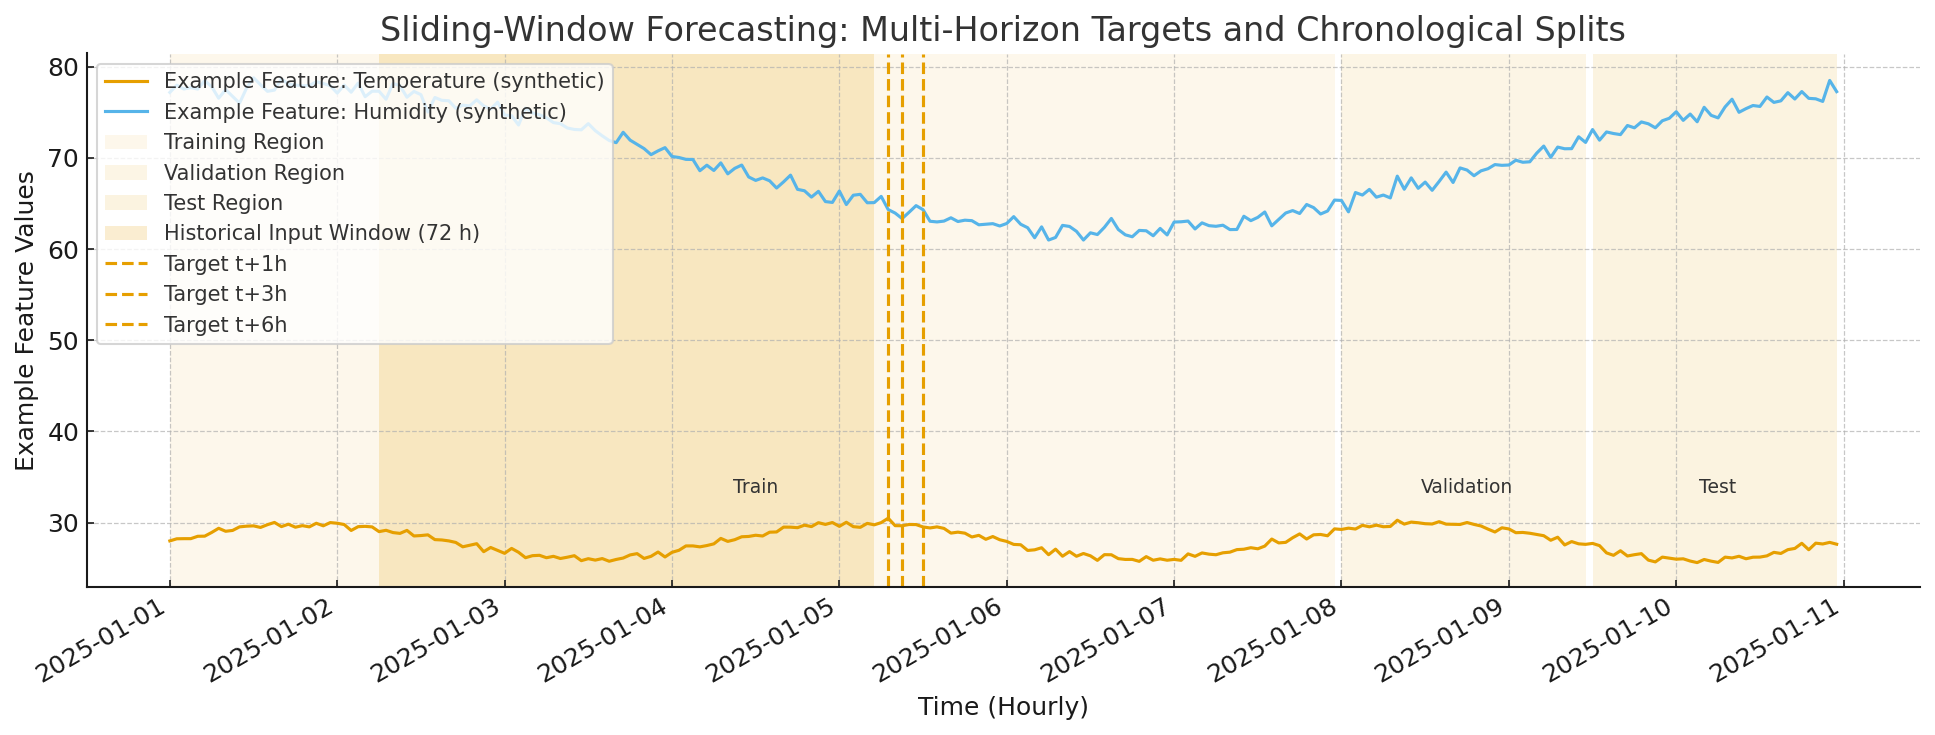

In [9]:
def build_one_dimensional_convolutional_model(
    input_window_length: int,
    number_of_input_features: int,
    dropout_rate: float = 0.10,
    first_block_filters: int = 16,
    second_block_filters: int = 32,
) -> keras.Model:
    """
    We want to build a tiny, clean 1D CNN that predicts next-hour temperature.
    We want something we can actually deploy on a microcontroller:
      - a small parameter count so it fits comfortably,
      - enough temporal receptive field to cover our 72-hour window,
      - layers that behave nicely after INT8 quantization

    Args:
        input_window_length: how many past hours each input sample contains (e.g., 72).
        number_of_input_features: feature count per hour (temp, humidity, pressure, wind, rain = 5).
        dropout_rate: gentle regularization to keep overfitting in check.
        first_block_filters: channels for the first convolutional block.
        second_block_filters: channels for the second (separable) block.

    Returns:
        A compiled Keras regression model that outputs one scalar temperature.
    """

    # Our inputs are [time_steps, features]. Batch dimension appears at runtime.
    input_layer: keras.layers.Input = keras.Input(
        shape=(input_window_length, number_of_input_features),
        name="input_window"
    )

    # ----- Convolutional Block 1 -----
    # First pass: capture short hourly trends with a slightly wider kernel (k=5).
    convolution_1: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=5,
        padding="same",
        activation="relu",
        name="conv1_k5_f16"
    )(input_layer)

    # Second pass: a tighter kernel (k=3) to refine features and add nonlinearity.
    convolution_2: layers.Layer = layers.Conv1D(
        filters=first_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="conv2_k3_f16"
    )(convolution_1)

    # We downsample the time axis by 2 so the model stays lightweight.
    pooled_features_1: layers.Layer = layers.MaxPooling1D(
        pool_size=2,
        name="maxpool1_stride2"
    )(convolution_2)

    # ----- Convolutional Block 2 (separable = cheaper) -----
    # SeparableConv1D keeps accuracy decent while cutting parameters and MACs.
    separable_convolution: layers.Layer = layers.SeparableConv1D(
        filters=second_block_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        name="sepconv_k3_f32"
    )(pooled_features_1)

    # Instead of Flatten + Dense (parameter heavy), we average across time.
    global_temporal_aggregate: layers.Layer = layers.GlobalAveragePooling1D(
        name="global_average_pool"
    )(separable_convolution)

    # A touch of dropout for stability; small rate so we do not underfit.
    regularized_features: layers.Layer = layers.Dropout(
        rate=dropout_rate,
        name="dropout_regularization"
    )(global_temporal_aggregate)

    # Final linear head: give us one float, the next-hour temperature.
    output_temperature: layers.Layer = layers.Dense(
        units=1,
        dtype="float32",  # keep outputs in float32; avoids accidental dtype promotions downstream
        name="predicted_temperature"
    )(regularized_features)

    # Wire up the graph.
    model: keras.Model = keras.Model(
        inputs=input_layer,
        outputs=output_temperature,
        name="lightweight_1d_cnn_forecaster"
    )

    # Defaults that work: Adam + MSE for training, MAE for easy-to-read error in °C.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [10]:
def build_model_for_tuning(
    hp: kt.HyperParameters,
    input_window_length: int,
    number_of_input_features: int
) -> keras.Model:
    """
    We are building a simple and flexible 1D CNN architecture for hyperparameter tuning.

    The goal here is to let Keras Tuner explore the most important parameters
    that influence model accuracy and size. We want to keep the model small enough
    for future deployment on embedded systems, while still learning useful weather patterns.

    Args:
        hp: The HyperParameters object that Keras Tuner uses during search.
        input_window_length: The number of timesteps in each input sequence.
        number_of_input_features: The number of features available per timestep.

    Returns:
        A compiled Keras model that Keras Tuner can train and evaluate.
    """

    # We start by defining the hyperparameters that the tuner will adjust.
    # These are the settings that usually make the biggest difference in model performance.

    # The dropout rate controls how much of the network we randomly deactivate during training.
    # It helps the model generalize better by preventing it from memorizing the training data.
    dropout_rate: float = hp.Float(
        "dropout_rate",
        min_value=0.0,
        max_value=0.3,
        step=0.05,
        default=0.0
    )

    # The first convolutional block sets how many filters we use for the initial feature extraction.
    # A filter count of 16 is small and efficient, but we allow the tuner to test higher values that might extract better features.
    first_block_filters: int = hp.Choice(
        "first_block_filters",
        values=[16, 32, 64],
        default=16
    )

    # The second convolutional block typically has more filters,
    # allowing the model to recognize higher-level temporal features in the data.
    second_block_filters: int = hp.Choice(
        "second_block_filters",
        values=[64, 128, 256],
        default=64
    )

    # The third block parameter is included for future flexibility.
    # Even if the base model does not always use this block,
    # having it in the search space allows us to easily expand later.
    third_block_filters: int = hp.Choice(
        "third_block_filters",
        values=[128, 256, 512],
        default=128
    )

    # The learning rate determines how large each step of the optimizer is during training.
    # Too high and we overshoot the optimal weights, too low and training becomes slow.
    learning_rate: float = hp.Choice(
        "learning_rate",
        values=[1e-2, 1e-3, 1e-4],
        default=1e-2
    )


    # Now that the tunable parameters are defined, we can build the model.
    # We pass these hyperparameters into our CNN constructor.
    model: keras.Model = build_one_dimensional_convolutional_model(
        input_window_length=input_window_length,
        number_of_input_features=number_of_input_features,
        dropout_rate=dropout_rate,
        first_block_filters=first_block_filters,
        second_block_filters=second_block_filters
    )


    # We compile the model so that it is ready for training.
    # The Adam optimizer is a reliable choice for this kind of regression problem.
    # We use Mean Squared Error as the loss and track Mean Absolute Error
    # so we can easily interpret errors in degrees Celsius.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )

    # We return the compiled model. Keras Tuner will handle the training loop automatically.
    return model

In [11]:
# -----------------------------
# Clean up any old tuner data
# -----------------------------
# We remove the previous tuner directory so we can start a clean search.
# This prevents shape mismatches or weight-loading errors from older runs.
# The tuner will recreate this directory automatically.
shutil.rmtree("keras_tuner_dir/weather_forecaster_tuning", ignore_errors=True)


# -----------------------------
# Create a descriptive project name
# -----------------------------
# We include both the number of features and the input window length in the name.
# This helps us keep track of which tuning runs belong to which dataset configuration.
project_name: str = f"weather_forecaster_tuning_nfeat{X_train.shape[-1]}_win{X_train.shape[1]}"


# -----------------------------
# Set up the Keras Tuner
# -----------------------------
# The tuner will call our build_model_for_tuning() function repeatedly,
# each time passing in a different combination of hyperparameters.
# It will train each model for a few epochs and record validation MAE for comparison.
tuner: kt.RandomSearch = kt.RandomSearch(
    hypermodel=lambda hp: build_model_for_tuning(
        hp,
        input_window_length=X_train.shape[1],
        number_of_input_features=X_train.shape[-1]
    ),
    objective="val_mae",             # we want to minimize validation MAE
    max_trials=5,                    # the tuner will test five different hyperparameter sets
    executions_per_trial=2,          # each configuration runs twice to average out randomness
    overwrite=True,                  # make sure we replace any previous tuning results
    directory="keras_tuner_dir",     # root folder where all tuner logs and checkpoints go
    project_name=project_name        # subfolder for this particular experiment
)


# -----------------------------
# Run the hyperparameter search
# -----------------------------
# The tuner will build and train multiple models using the given hyperparameters.
# Each model will train for a certain # of epochs unless the validation metric stops improving.
# We pass validation data so the tuner can rank the models properly.
tuner.search(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=40,
    batch_size=64
)


# -----------------------------
# Retrieve the best hyperparameters
# -----------------------------
# Once the search finishes, we can query the tuner to find the best combination
# of hyperparameters according to validation MAE.
best_hyperparameters: kt.HyperParameters = tuner.get_best_hyperparameters(num_trials=1)[0]


# -----------------------------
# Build a new model with the best settings
# -----------------------------
# We create a completely fresh model using the best hyperparameters.
# This ensures that the model starts with new weights and no leftover state.
best_model: keras.Model = build_model_for_tuning(
    hp=best_hyperparameters,
    input_window_length=X_train.shape[1],
    number_of_input_features=X_train.shape[-1]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.25              |0.25              |dropout_rate
64                |64                |first_block_filters
64                |64                |second_block_filters
256               |256               |third_block_filters
0.001             |0.001             |learning_rate



FatalTypeError: Expected the model-building function, or HyperModel.build() to return a valid Keras Model instance. Received: <tf_keras.src.engine.functional.Functional object at 0x7f004de12720> of type <class 'tf_keras.src.engine.functional.Functional'>.

In [ ]:
# now that we've tuned the hyperparameters for our full model, we move on to pruning
# we copy the tuned model so we can experiment safely
model_for_pruning: keras.Model = keras.models.clone_model(best_model)
model_for_pruning.set_weights(best_model.get_weights())

# We choose a gentle target sparsity so we do not crush accuracy
target_sparsity: float = 0.50

# We set up a pruning schedule that ramps sparsity gradually
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=target_sparsity,
    begin_step=0,
    end_step=1000
)

pruning_params: Dict[str, Any] = {"pruning_schedule": pruning_schedule}
pruned_model: keras.Model = tfmot.sparsity.keras.prune_low_magnitude(
    model_for_pruning,
    **pruning_params
)

# We compile with the same loss and metric as before
pruned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=best_model.loss,             # keep the tuned loss
    metrics=["mae"]
)

# A pruning callback updates masks during training
update_pruning_step = tfmot.sparsity.keras.UpdatePruningStep()

# We fine tune for a short period. If accuracy drops, add more epochs with a lower learning rate.
pruning_history = pruned_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_validate, y_validate),
    epochs=10,
    batch_size=128,
    callbacks=[update_pruning_step],
    verbose=1
)

# We strip pruning wrappers to obtain a standard Keras model again
model_for_export: keras.Model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# then we check test performance after pruning
test_loss_value, test_mae_value = model_for_export.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE after pruning (degrees C): {float(test_mae_value):.3f}")